<a href="https://colab.research.google.com/github/mdhabibi/Variational_AutoEncoders/blob/main/beta_VAE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Implementation and Analysis of $\beta$-Variational Autoencoders on CIFAR-10 Dataset**

This notebook explores the use of **$\beta$-Variational Autoencoders ($\beta$-VAEs)** for the **CIFAR-10 dataset**, a popular dataset used in image processing and computer vision tasks. The CIFAR-10 dataset consists of 60,000 `32x32` color images in `10` classes, with `6000` images per class. Our primary aim is to train a VAE to encode these images into a lower-dimensional latent space, and then reconstruct the original images from this encoded representation. The notebook also delves into the evaluation of the trained model, comparing the original and reconstructed images for a comprehensive understanding of the model's performance.

**Step-01: Importing required modules**

In [ ]:
import numpy as np                          # Used for handling large data arrays
import matplotlib.pyplot as plt             # Used for creating visualizations
from matplotlib.colors import ListedColormap
import seaborn as sns

import keras                                # High-level neural networks API

from   keras.datasets import cifar10        # Dataset of color images
# Various building blocks for neural networks
from   keras.layers    import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from   keras.models    import Model         # Used for defining and training models

# For better control of the training process
from   keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from   keras import backend as K
# Note: The backend above provides a bridge between Keras and
# its underlying computation libraries, such as TensorFlow.

from keras import regularizers

from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator # Used for data augmentation




---


# **(1) INPUT**


---



**Step-02: Loading the cifar10 dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train and x_test are arrays of image data, and y_train and y_test are arrays of class labels (0-9),
# each representing a class of image: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

170498071/170498071 [==============================] - 4s 0us/step


**Step-03: Data Preprocessing**

In [ ]:
# Check the type of elements in x_train.
print(x_train.dtype)
print(x_train.shape)

uint8
(50000, 32, 32, 3)


1.   Converting and Normalizating

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.

In [ ]:
# Check again the type of elements in x_train after normalization.
print(x_train.dtype)
print(x_train.shape)

float32
(50000, 32, 32, 3)


#**Augmentation data (for small datasets)**

Create an instance of the ImageDataGenerator class:

This class generates batches of tensor image data with real-time data augmentation (only on x_train) in each epoch in training process


In [ ]:
# define data preparation
datagen = ImageDataGenerator(
    rotation_range     = 15,      # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range  = 0.1,     # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,     # randomly shift images vertically (fraction of total height)
    horizontal_flip    = True,    # randomly flip images
    vertical_flip      = False    # do not randomly flip images vertically. This is not a good way for images in cifar10.
)

# fit parameters from data
datagen.fit(x_train)

# configure batch size. Note that it should be same as the batch size in compiler
batch_size = 64

# prepare an iterators to scale images
train_iterator = datagen.flow(x_train, y_train, batch_size=batch_size)

*   Retrieving the original width and height of the images in the cifar10
dataset

In [ ]:
img_num_train = x_train.shape[0]
img_width     = x_train.shape[1]
img_height    = x_train.shape[2]
num_channels  = x_train.shape[3]

print(f"The CIFAR-10 train set contains {img_num_train} images, each with dimensions:"
      f"\n(width x height x channels) = ({img_width} x {img_height} x {num_channels}),"
      f"\nin which there are {num_channels} channels, representing colored images.")

img_num_test  = x_test.shape[0]
print(f"The CIFAR-10 test set also contains {img_num_train} images with the same dimensions as the train.")

The CIFAR-10 train set contains 50000 images, each with dimensions:
(width x height x channels) = (32 x 32 x 3),
in which there are 3 channels, representing colored images.
The CIFAR-10 test set also contains 50000 images with the same dimensions as the train.






*   Defining the shape of the input data







In [ ]:
num_channels = 3

# The training and test datasets are already in the correct shape. So, I don't need to reshape
# it anymore like what I have done for the MNIST dataset.

# Defining the shape of the input data which will be used to configure the neural network
input_dimensions = (img_height, img_width, num_channels)

print(f"Dimensions of each image that will be fed into the model are"
      f"\n(img_height, img_width, num_channels)={input_dimensions}.")
print(x_train.shape)
print(x_test .shape)

Dimensions of each image that will be fed into the model are
(img_height, img_width, num_channels)=(32, 32, 3).
(50000, 32, 32, 3)
(10000, 32, 32, 3)




*   Visualizing the data to see a few arbitrary images (Only for checking!)




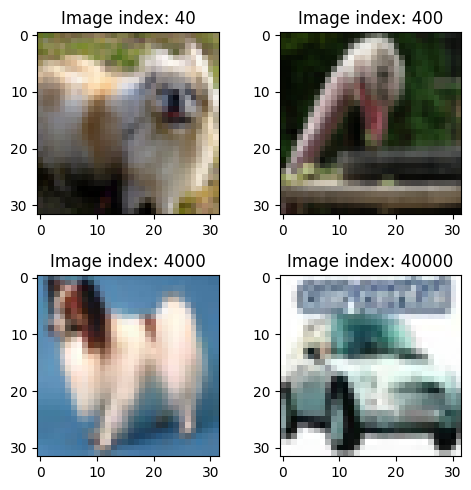

In [ ]:
# Define indices of images to be viewed (Arbitrary indices)
image_indices = [40, 400, 4000, 40000]

# Set up the figure
plt.figure(figsize = (5, 5))

for i, img_index in enumerate(image_indices):
    plt.subplot(2, 2, i+1)
    plt.imshow(x_train[img_index], interpolation='nearest')
    plt.title(f'Image index: {img_index}')

plt.tight_layout()
plt.show()


**Note:** The images from the CIFAR-10 dataset are relatively low resolution (`32x32` pixels), and each pixel in an image is represented by a `3`-element vector (for the red, green, and blue channels).

When we are displaying these images at a size larger than their original `32x32` pixels, such as in a plot above, the image viewing software needs to interpolate the values for the new pixels that are created during this enlargement process. This interpolation can sometimes make the images appear blurry.

This is simply a side-effect of the visualization process and does not impact the actual data that our model will be trained on. But for practise and providing more possibilities for encoder to get more trained,I have added augmentation snippet above.  



---


#**(2) Encoder**


---



In [ ]:
# Setting up the latent dimension. It seems that 50, 100, and 200 dimensions for the latent space doesn't
# affect considerably on the entire VAE model.
latent_space_dim = 200

*   Defining the input layer for the encoder

In [ ]:
# It creates an input layer for the encoder where the shape of the input data is specified.
encoder_input_layer = Input(shape = input_dimensions, name = 'encoder_input_layer')

*   Convolution layers

**Note:** Here, I have added more layers to my model just to show how it can be done. But with lighter complexity in the layers, it also works.

In [ ]:
# First convolution block
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_input_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2))(encoder_layer)

# Second convolution block
encoder_layer = Conv2D(128, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(128, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(128, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2))(encoder_layer)

# Third convolution block
encoder_layer = Conv2D(256, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(256, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(256, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2))(encoder_layer)

In [ ]:
# The shape of the tensor x (i.e., conv_shape) is stored because it will be used later
# in the code when building the decoder part of the VAE.
# This allows the decoder to start its reconstruction process from a tensor that
# has the same shape as the output tensor of the encoder.

encoder_output_shape = K.int_shape(encoder_layer)

print(f"The shape of the tensor at the output of the encoder"
      f"\n(and the input to the decoder) is: {encoder_output_shape}")

The shape of the tensor at the output of the encoder
(and the input to the decoder) is: (None, 4, 4, 256)


*   Flattening the 3D output from the convolutional layers

In [ ]:
# The output from the convolutional layers is a 3D tensor (height, width, channels) for each image.
# However, the following layers (dense layers) expect input as a 1D tensor per image in the batch.
# Therefore, we need to flatten the 3D tensor into a 1D tensor using Flatten()(encoder_stage4).

encoder_layer = Flatten()(encoder_layer)
print(encoder_layer.shape)

(None, 4096)


*   Adding a Dense layer

**Note:** Here I add l2 regularization to the dense layer. The L2 regularization, also known as weight decay, adds a penalty to the loss function based on the square value of the magnitude of the weights. This encourages the model to have smaller weights, making the output less sensitive to the input, and therefore reducing overfitting.

In [ ]:
# After extracting features through convolutional layers and flattening, we use a Dense layer.
# This layer learns to recognize patterns by combining the features extracted from the previous layers.
# The Dense layer is a type of layer that performs a linear operation on its input,
# followed by an activation function.

# Define l2 regularizer
reg = regularizers.l2(0.01)

encoder_layer = Dense(32, activation='relu', kernel_regularizer=reg)(encoder_layer)

print(encoder_layer.shape)

(None, 32)


*   Output layer

 A crucial transition between the encoder and the latent space (the final step of the encoder and the first step of defining the latent space in a VAE).

In [ ]:
# Creating two Dense layers to generate the parameters of the probability distribution of the latent space.
# One Dense layer (mu_layer) for the means, and another Dense layer (sigma_layer) for the standard deviations.

mu_layer    = Dense(latent_space_dim, name = 'latent_mu')(encoder_layer)

sigma_layer = Dense(latent_space_dim, name = 'latent_sigma')(encoder_layer)

print(f"mu_layer shape: {mu_layer.shape}, sigma_layer shape: {sigma_layer.shape}")

mu_layer shape: (None, 200), sigma_layer shape: (None, 200)




---


#**(3) Latent space:**


---



**Reparameterization trick**

When we want to sample a point from the normal (Gaussian) distribution defined by $\mu$ and $\sigma$, we use a random process. This random process is not differentiable, which means we can't compute gradients through it to calculate loss function. And since backpropagation, the mechanism by which neural networks are trained, requires computing gradients, this presents a problem.

The reparameterization trick is a clever way around this problem. Instead of directly sampling from the distribution defined by $\mu$ and $\sigma$, we sample (choose a random number) from a standard normal distribution ($\mu=0$ and $\sigma=1$), and then we shift (add $\mu$) and scale (multiply by $\sigma$) this sampled point. This new method for generating $z$, ($z = \mu + \sigma * \epsilon$), is differentiable with respect to $\mu$ and $\sigma$ because it does not involve sampling $\mu$ and $\sigma$ directly.

In [ ]:
def sample_z(args):
    """Generate a sample from the Gaussian distribution defined by args=(mu, sigma).

    Args:
    mu_layer:    The mean of the Gaussian distribution.
    sigma_layer: The log standard deviation of the Gaussian distribution.

    Returns:
    A sample from the Gaussian distribution.
    """
    mu_layer, sigma_layer = args
    batch_size = K.shape(mu_layer)[0]

    dim = K.int_shape(mu_layer)[1]

    # Generate a random sample from a standard normal distribution with the same shape
    epsilon = K.random_normal(shape = (batch_size, dim))

    # Scale and shift the sample by mu and sigma to create a sample from the original Gaussian distribution
    return mu_layer + K.exp(sigma_layer / 2) * epsilon


In [ ]:
z = Lambda(sample_z, output_shape = (latent_space_dim, ), name = 'z')([mu_layer, sigma_layer])

#**Encoder Model**

To encapsulate the encoder part of the VAE into a standalone model that can be trained and used independently.

In [ ]:
# Model(encoder_input_layer, output, name)
encoder_model = Model(encoder_input_layer, [mu_layer, sigma_layer, z], name = 'encoder_model')

# Save the model
encoder_model.save('encoder_model_cifar10.h5')

In [ ]:
print(encoder_model.summary())

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_layer (InputLaye  [(None, 32, 32, 3)]  0          []                               
 r)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['encoder_input_layer[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d_1[0][0]']   



---


#**(4) Decoder**


---



In [ ]:
# It creates an input layer for the decoder where the shape of the input data is specified by the latent space dimension.
decoder_input_layer = Input(shape = (latent_space_dim, ), name = 'decoder_input_layer')



*   The first layer of decoding



In [ ]:
# The Dense layer performs a linear operation on the layer's input,
# transforming it into a space of dimension equal to the number of its units.
num_units = encoder_output_shape[1] * encoder_output_shape[2] * encoder_output_shape[3]
decoder_layer = Dense(num_units, activation='relu', kernel_regularizer=reg)(decoder_input_layer)

#decoder_layer = Dense(num_units, activation='relu')(decoder_input_layer)
print(f"Shape of the initial dense layer in the decoder: {decoder_layer.shape}")

Shape of the initial dense layer in the decoder: (None, 4096)




*   Reshaping





In this line of code, the output of the Dense layer in the decoder, which is a flat vector, is reshaped back to the shape of the output from the last Conv2D layer in the encoder part.

In [ ]:
reshape_dims = (encoder_output_shape[1], encoder_output_shape[2], encoder_output_shape[3])

decoder_layer = Reshape(reshape_dims)(decoder_layer)
print(f"Shape of the reshaped layer in the decoder: {decoder_layer.shape}")
# Compare it with dimension of conv2d_3 (Conv2D)

Shape of the reshaped layer in the decoder: (None, 4, 4, 256)


In [ ]:
# First convolution block (upsampling)
decoder_layer = Conv2DTranspose(256, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(256, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(256, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = UpSampling2D(size=(2, 2))(decoder_layer)

# Second convolution block (upsampling)
decoder_layer = Conv2DTranspose(128, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(128, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(128, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = UpSampling2D(size=(2, 2))(decoder_layer)

# Third convolution block (upsampling)
decoder_layer = Conv2DTranspose(64, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(64, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(64, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = UpSampling2D(size=(2, 2))(decoder_layer)



*   The final layer of the decoder part of the autoencoder



After this layer, the decoder output will have the same dimensions as the original input to the encoder (assuming that's what num_channels equals).

In [ ]:
# Final layer to reconstruct the original input
decoder_output_layer = Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(decoder_layer)
print(f"Shape of the output layer in the decoder: {decoder_output_layer.shape}")

Shape of the output layer in the decoder: (None, 32, 32, 3)


#**Decoder model**

In [ ]:
decoder_model = Model(decoder_input_layer, decoder_output_layer, name = 'decoder_model')

# Save the model
decoder_model.save('decoder_model_cifar10.h5')

In [ ]:
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_layer (InputL  [(None, 200)]            0         
 ayer)                                                           
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4, 4, 256)        590080    
 ranspose)                                                       
                                                     



---


#**(5) Output**


---



In [ ]:
reconstructed_output = decoder_model(z)
# reconstructed_output is the output of the VAE. It's the reconstruction of
# the original input data after being encoded to a latent representation and then decoded.

print(f"The type  of 'reconstructed_output' is: {type(reconstructed_output)}")
print(f"The shape of 'reconstructed_output' is: {reconstructed_output.shape}")

The type  of 'reconstructed_output' is: <class 'keras.engine.keras_tensor.KerasTensor'>
The shape of 'reconstructed_output' is: (None, 32, 32, 3)




---


#**Loss function**


---



In [ ]:
class VAELossLayer(keras.layers.Layer):
    """
    Custom Keras layer that calculates the loss (reconstruction + KL divergence)
    of the Variational AutoEncoder (VAE)
    """

    def calculate_loss(self, original_input, reconstructed_output, mu, sigma):
        """
        Calculates VAE loss, which is the sum of the reconstruction loss and KL-divergence loss
        """
        original_input  = K.flatten(original_input)
        reconstructed_output = K.flatten(reconstructed_output)

        # Reconstruction loss - binary crossentropy is used as the final layer uses sigmoid activation
        reconstruction_loss = keras.metrics.binary_crossentropy(original_input, reconstructed_output)

        # KL divergence loss - acts as a regularizer
        kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)

        # Making sure that kl_loss is scalar
        kl_loss = K.mean(kl_loss)

        # Return all losses
        return reconstruction_loss, kl_loss, reconstruction_loss + kl_loss

    def call(self, inputs):
        """
        Computes the loss and adds it to the layer's losses
        """
        original_input = inputs[0]
        reconstructed_output = inputs[1]
        mu = inputs[2]
        sigma = inputs[3]

        reconstruction_loss, kl_loss, total_loss = self.calculate_loss(original_input, reconstructed_output, mu, sigma)
        self.add_loss(total_loss, inputs=inputs)
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')

        # Returns the original layer inputs
        return original_input

**Adding the VAE Loss computation layer to the model**

In [ ]:
vae_loss_output = VAELossLayer()([encoder_input_layer, reconstructed_output, mu_layer, sigma_layer])

print(f"The type of 'vae_loss_output' is: {type(vae_loss_output)}")
print(f"The shape of 'vae_loss_output' is: {vae_loss_output.shape}")

The type of 'vae_loss_output' is: <class 'keras.engine.keras_tensor.KerasTensor'>
The shape of 'vae_loss_output' is: (None, 32, 32, 3)




---
#**Final VAE Model Creation**


---





In [ ]:
final_vae_model = Model(encoder_input_layer, vae_loss_output, name = 'vae_model')

# Save the model
final_vae_model.save('final_vae_model_cif.h5')

**Compile VAE**


In [ ]:
opt = Adam(learning_rate = 0.00001)  # 0.001 is default
final_vae_model.compile(optimizer=opt, loss=None)

In [ ]:
final_vae_model.summary()

Model: "vae_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_layer (InputLaye  [(None, 32, 32, 3)]  0          []                               
 r)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['encoder_input_layer[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d_1[0][0]']       



---


#**Training the Variational Autoencoder**


---




In [ ]:
# To have more control over training, I've added callbacks that terminate training
# if the validation loss doesn't improve after 10 epochs and save the best model weights.

# To dynamically adjust the learning rate during training when the validation loss has stopped improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.000001)

callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10),
    ModelCheckpoint('best_model_cifar10.h5', monitor = 'val_loss', save_best_only = True),
    reduce_lr  # Add this line
]

# with augmentation
batch_size=64
history = final_vae_model.fit(train_iterator,
                              steps_per_epoch = len(x_train) // batch_size,
                              validation_data = (x_test, None),
                              epochs          = 50,
                              callbacks       = callbacks
                              )

Epoch 1/50
781/781 [==============================] - 54s 54ms/step - loss: 3.9829 - reconstruction_loss: 0.6870 - kl_loss: 9.7700e-05 - val_loss: 2.9972 - val_reconstruction_loss: 0.6542 - val_kl_loss: 6.9421e-04 - lr: 1.0000e-05
Epoch 2/50
781/781 [==============================] - 42s 53ms/step - loss: 2.3431 - reconstruction_loss: 0.6313 - kl_loss: 0.0011 - val_loss: 1.8197 - val_reconstruction_loss: 0.6231 - val_kl_loss: 0.0015 - lr: 1.0000e-05
Epoch 3/50
781/781 [==============================] - 40s 51ms/step - loss: 1.4744 - reconstruction_loss: 0.6177 - kl_loss: 0.0016 - val_loss: 1.1982 - val_reconstruction_loss: 0.6170 - val_kl_loss: 0.0017 - lr: 1.0000e-05
Epoch 4/50
781/781 [==============================] - 40s 51ms/step - loss: 1.0201 - reconstruction_loss: 0.6120 - kl_loss: 0.0018 - val_loss: 0.8852 - val_reconstruction_loss: 0.6122 - val_kl_loss: 0.0018 - lr: 1.0000e-05
Epoch 5/50
781/781 [==============================] - 40s 51ms/step - loss: 0.8022 - reconstruction_



---


#**Visualization**


---



In [ ]:
# Obtain mu, sigma, and z from the encoder
mu, sigma, z = encoder_model.predict(x_test)
print(mu.shape)
print("Shape of y_test:", y_test.shape)

313/313 [==============================] - 1s 3ms/step
(10000, 200)
Shape of y_test: (10000, 1)


In [ ]:
# Can we reconstruct the image only using the decoder part? and only with z?
reconstructed_images = decoder_model.predict(z)

313/313 [==============================] - 1s 3ms/step


**Reconstructed image using full model (VAE) and decoder model:**

1/1 [==============================] - 0s 20ms/step


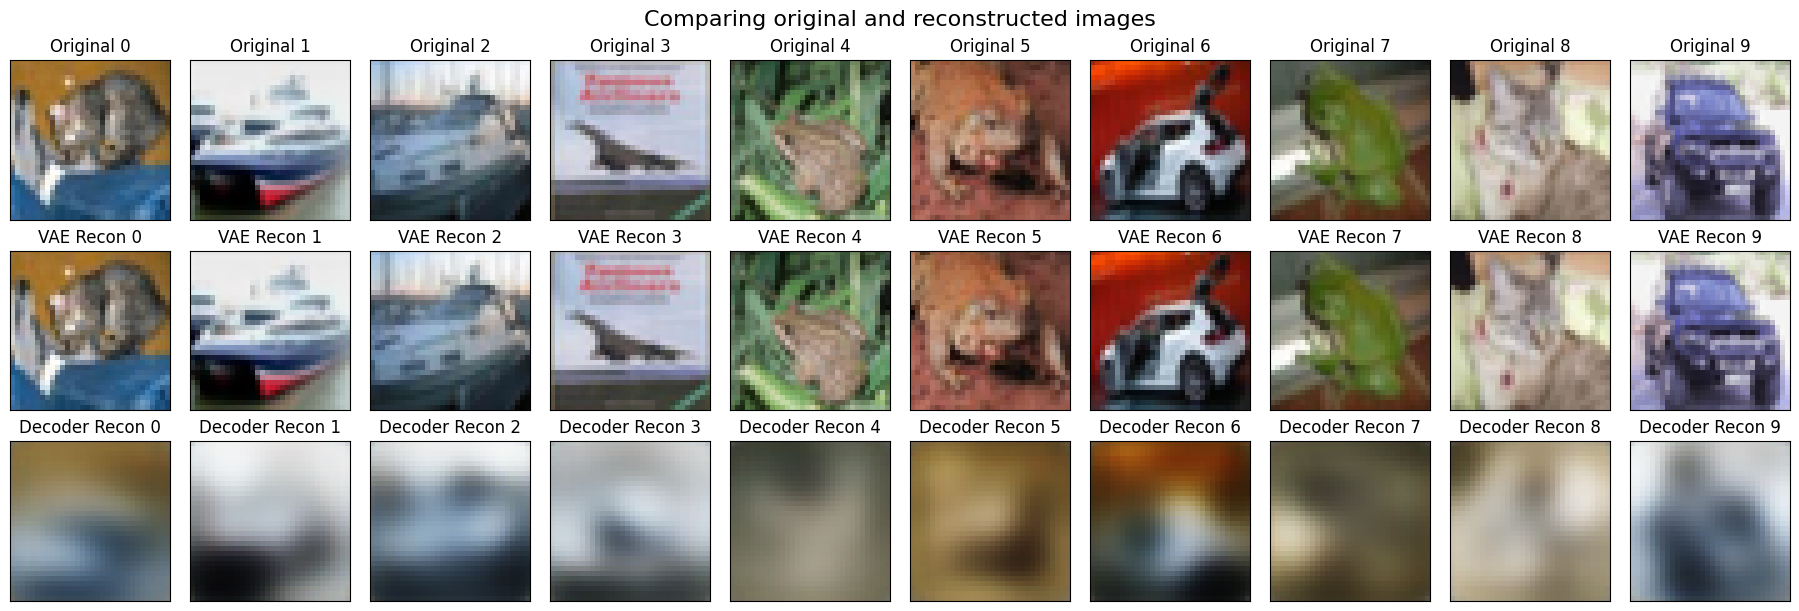

In [ ]:
num_images = 10
fig, axes = plt.subplots(3, num_images, figsize=(18, 6), constrained_layout=True)

for i in range(num_images):

    # Display original
    ax = axes[0, i]
    original_img = x_test[i]
    ax.imshow(original_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Original {i}")

    # Display reconstruction from VAE (encoder+decoder) model
    ax = axes[1, i]
    reconstructed_img_vae = final_vae_model.predict(x_test[i].reshape(1, 32, 32, 3))
    ax.imshow(reconstructed_img_vae.reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"VAE Recon {i}")

    # Display reconstruction from only decoder model
    ax = axes[2, i]
    mu, sigma, z = encoder_model.predict(x_test[i].reshape(1, 32, 32, 3))
    reconstructed_img_decoder = decoder_model.predict(z)
    ax.imshow(reconstructed_img_decoder.reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Decoder Recon {i}")

plt.suptitle("Comparing original and reconstructed images", fontsize=16)

plt.show()



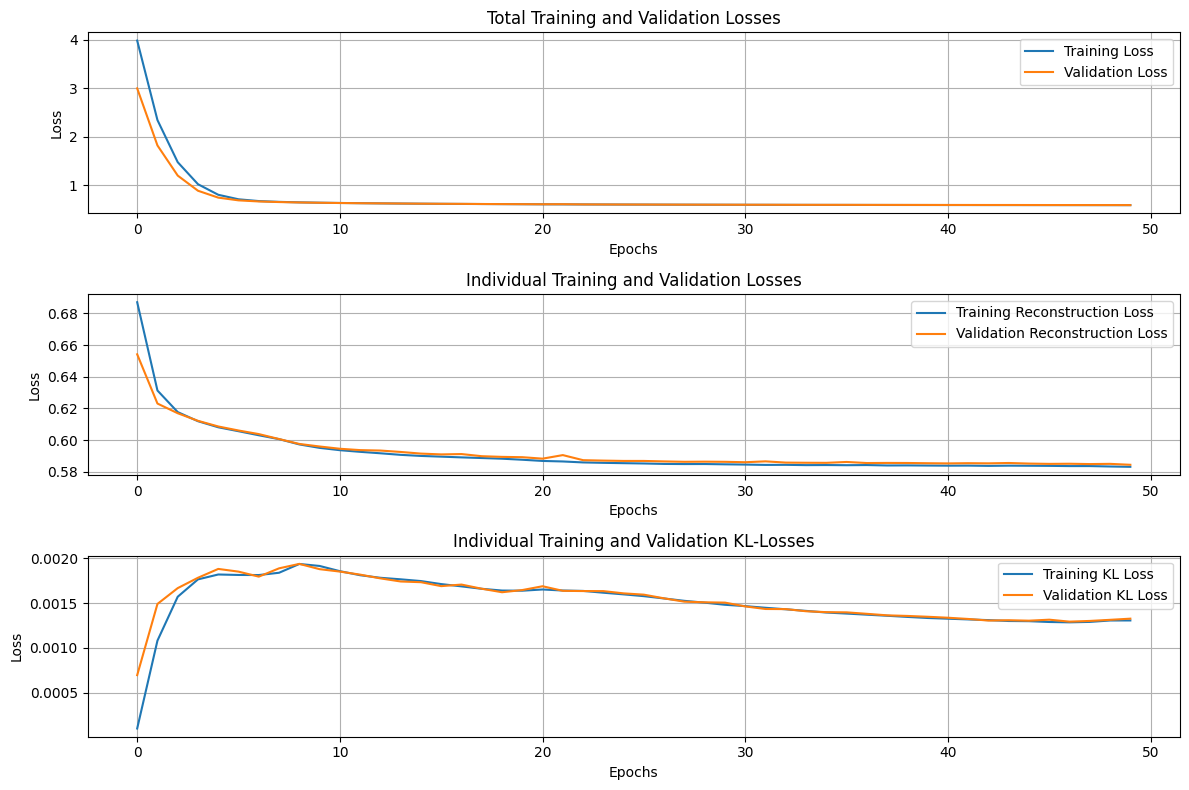

In [ ]:
# plot training and validation losses
plt.figure(figsize=(12, 8))

# Total loss
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Individual losses
plt.subplot(3, 1, 2)
plt.plot(history.history['reconstruction_loss'], label='Training Reconstruction Loss')
plt.plot(history.history['val_reconstruction_loss'], label='Validation Reconstruction Loss')
plt.title('Individual Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Individual losses
plt.subplot(3, 1, 3)
plt.plot(history.history['kl_loss'], label='Training KL Loss')
plt.plot(history.history['val_kl_loss'], label='Validation KL Loss')
plt.title('Individual Training and Validation KL-Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




*   **Individual Training and Validation KL-Losses:**

In the initial epochs, the model is learning to reconstruct the inputs, hence the KL loss will be low as the model is focusing more on minimizing the reconstruction loss. As the epochs proceed, the model starts to learn the structure of the data in the latent space, the KL loss increases because the model is trying to match the learned latent distribution with the prior distribution.

However, after a certain point, the KL loss starts to decrease which indicates that the distribution of the encoded input is getting closer to the prior distribution (standard normal). This is expected behavior in a VAE model where the KL loss first increases and then decreases.








